# Tackling Text Readability with Unsupervised Large Language Models


### **INTRODUCTION** ###

In an effort to calculate a clear, intuitive readability score for a given document, I used BERT to compute a **Ranked Sentence Readability Score (RSRS)** for a given document. The Ranked Sentence Readability Score calculates readability based on the likelihood that a word will appear next in a sentence. Using likelihood, sentence length, and word position, I calculated the RSRS for each sentence in a document, and then averaged the sentences' scores to produce the readability score for the document as a whole. 

To develop a readablity score that is clear and intuitive without losing the nuance and rigor of the RSRS, I used three techniques to map RSRS: min-max scaling, z-score normalization, and boxcox transformation.

To measure how well these transformed scores align with human experience, I had planned to create a simple demonstration of the program. For two random samples from my dataset, I had planned to calculate the raw readability score along with the scaled, standardized, and BoxCox-transformed scores. I planned to ask users to select the score that best represented their experience reading the document. However, I did not have the time to integrate human feedback in this experiment. From cursory first-glance analysis of the article with the maximum readability score of 200 randomly sampled articles, generating a simple percentage scale of readability appears to be most effective at producing a clear, intuitive readability score. 

### **DATA** ###

Given that BERT is such a context-based model, the database I chose was critical in shaping how readability would be measured. The Wikipedia database provides a useful context for measuring readability because of the crowd-sourced nature and sheer volume of Wikipedia articles available. Articles are written to be easily understood by anyone, providing a good baseline for what we define as **readable.** 

In Martinic et. al, data was taken from the Corpus of English Wikipedia and the Corpus of Simple Wikipedia articles as of 2018. They divided the corpus into three sub-corpora, Wiki-normal, Wiki-simple, and Wiki-balanced. Altogether, the three corpora contained `390,000` randomly selected articles, `1,500,000` sentences, and over `30 million` tokens (Martinic et. al, 2021). 

For the purposes of my experiment, I used a sample of the Corpus of English Wikipedia that contains approximately `205,328` articles. 

#### Setting Up Tensorflow ####
Here, I set up Tensorflow and other relevant imports for in my analysis, including the specific BERT model I use, the Google Bucket I use to store my database, and the HuggingFace datasets library I get my corpus from. I also include any relevant dependencies for those imporrts. 

In [ ]:
!pip install -q -U "tensorflow-text==2.12.*"

In [ ]:
!pip install -q -U tf-models-official==2.12.*

In [ ]:
import os
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_cased_L-24_H-1024_A-16'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


In [ ]:
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = True #@param {type:"boolean"}
BUCKET = 'berts_bucket' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = "gs://berts_bucket"
  from google.colab import auth
  auth.authenticate_user()

tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: gs://berts_bucket *****


In [ ]:
!pip install datasets

In [ ]:
!pip install apache_beam mwparserfromhell

### Looking at Data ###

In [ ]:
#@title Dataset Imports
#@markdown Imports required for Wikipedia sample dataset 
import pandas as pd
import numpy as np
from datasets import load_dataset
data = load_dataset("wikipedia", "20220301.simple")

In [ ]:
#Cleaning and processing Dataset of type Dataset.Dict into pd.DataFrame 
data['train']
simple_df = pd.DataFrame(data['train'])
# simple_df = simple_df.replace(r'\\|[\']|\n','', regex=True) 
simple_df.head()

,id,url,title,text
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...


Here is a randomly sampled article from my processed Wikipedia corpus:

In [ ]:
import random
clean_df = simple_df.replace(r'\\|[\']|\n','', regex=True) 
seed = np.random.randint(0,205328)
clean_df['text'][seed]

'The Grand Korean Waterway plan, officially known as the Pan Korea Grand Waterway (한반도대운하, 韓半島大運河), consists of 3 canals. They are called the Seoul-Busan Canal (GyeongBu Canal,경부운하), the Honam Canal (호남운하), and the North Korea Canal (BukHan Canal, 북한운하).The Seoul-Busan Canal runs between Seoul and Busan,  two of South Koreas largest cities, and connecting the Han River and Nakdong River. Then the Honam Canal, which runs through ChungCheongBuk-do, ChungCheongNam-do, JeollaBuk-do, and JeollaNam-do, connects Geum River and YeongSan River. The North Korea Canal would connect SinUiJu-Pyongyang-GaeSeong, Wonsan-GaeSeong. The canal was a project headed by Lee Myung Bak, who South Koreas president  from 2008 to 2013. It is hugely controversial.  Many Koreans object to this plan. Former president Lee said that he would not carry out this plan if many people objected to this idea, but there was a person who works in the Korea Institute of Construction Technology (한국건설기술연구원) has confessed that go

### **METHOD** ###

Here, I replicate a portion of the Martinic et. al experiment using BERT, a family of large language models that use the context around a word to make predictions. BERT works by learning how words are related in a given **context.** Rather than reading a sequence of words from left to right, it takes in an entire sequence at once and learns the context of a given word based on its surroundings. Using that context, BERT produces two predictions:

> **Masked Language Modeling** <br> BERT masks 15% of words in a sequence, then attempts to predict **the original value of the masked tokens** using the non-masked words for context. <br>
> text: `"The Milky Way is a [MASK] galaxy."` <br>
output: `The Milky Way is a spiral galaxy.` 

> **Next Sentence Predition** <br> BERT separates the document into pairs of sentences. For half of the pairs, it *replaces* the second sentence with a random sentence from the document. Then, BERT attempts to predict **whether the second sentence in a given pair is the subsequent sentence in the original document.**

For ease of use, I created a class Bertie that contains all the preprocessing methods I used as well as the BERT model itself.  



In [ ]:
#@title Program setup and required imports
import json
import math 
import random
import numpy as np
import nltk
nltk.download('punkt')
from scipy.special import softmax
np.set_printoptions(precision=5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install transformers

In [ ]:
#@title Bertie Object
class Bertie():
  #@markdown Initializes Bertie object with <br> FastPieceBertTokenizer, a pre-trained tokenizer from Tensorflow 
  #@markdown <br> Also initializes dictionary of special tokens associated with the FastPieceBertTokenizer
  def __init__(self):
    self.tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
      vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
      lower_case=True)
    self.special_dict = self.tokenizer.get_special_tokens_dict()
    self.max_seq_length = 128
    self.packer = None
    self.model = None
  #@markdown
  def getTokenizer(self):
    return self.tokenizer
  
  def getPacker(self, seq_length):
    self.packer = tfm.nlp.layers.BertPackInputs(
    seq_length=seq_length,
    special_tokens_dict = self.special_dict)
    return self.packer
  
  def getBertie(self):
    return self.model
  
  def makeBertie(self):
    bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
    config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
    encoder_config = tfm.nlp.encoders.EncoderConfig({
        'type':'bert',
        'bert': config_dict
    })
    bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
    self.model = tfm.nlp.models.BertTokenClassifier(network=bert_encoder, num_classes=2)


In [ ]:
#@title Preprocesses data
#@markdown Returns tensorflow tensor ready to use for classification
# Parameters
  # bertie: Model object
  # sample: sentence
  # max_seq_length: length of sentence
def preprocess(bertie, sentence, max_seq_length):
  tokenizer = bertie.getTokenizer()
  packer = bertie.getPacker(max_seq_length)

  toks = tokenizer([sentence])
  packed = packer([toks])

  return packed


#### **COMPUTING WNLL** ####
For the purposes of my analysis, I use Masked Language Modeling at the token level. Once each article is separated into sentences, I separate each sentence into tokens. For each token, I use BERT to predict the likelihood that a token will appear next in the sentence. 

Using this probability, I calculate the word negative log likelihood for each word using the following formula:

$
WNLL = -(y_{t}logy_{p} + (1-y_{t})log(1-y_{p}))
$

where y<sub>p</sub> is the probability of the word predicted by BERT, and y<sub>t</sub> is 1 for the word in the vocabulary that actually appears next in the sequence and 0 for all other words in the vocabulary. 

In [ ]:
#@title Calculates WNLL Scores 
#@markdown For all predicted probabilities and classes in a sentence, returns list of WNLL scores sorted in ascending order.
# Parameters
  # probs: list of BERT's predicted probabilities for each word token
  # sent: list of word tokens 
  # returns list of WNLL scores for each word token 
def compute_wnll(probs, y_subt, sentence):
    wnlls = {}
    y_subp = probs                          

    if(len(y_subp) != len(sentence.split())):     
        error = "Number of predicted probabilities did not match number of tokens in sentence.\n"
        print(sentence)
        print("\n pred. probs: ", y_subp)
        print("\n ndim: ", str(y_subp.ndim))
        print("\n predicted classes: ", y_subt)
        print("\nlength of sentence: " + str(len(sentence.split())) + error)
        return 0
    for index in range(0, len(y_subp)):
      isNext = y_subt[index]
      prob = y_subp[index]
      if(prob==1):
        wnll = -1*(isNext * math.log(1))
      else:
        wnll = float(-1*(isNext * math.log(prob) + (1-isNext) * math.log(1-prob)))
      wnlls.update({wnll:index})
    sorted_wnlls = sorted(wnlls)
    return sorted_wnlls 


#### **COMPUTING READABILITY** ####
Next, all words are sorted in ascending order by WNLL score, and then I calculated ranked sentence readability score:

$
RSRS = \frac{\sum{_{i=1}^{S}} \sqrt{i} \cdot WNLL(i)}{S}
$

where i is the index of a word determined by WNLL, and S is the sentence length.

In [ ]:
#@title Calculates Ranked Sentence Readability Score 
#@markdown For each sentence, takes in list of WNLL scores and returns sentence-level RSRS.
# wnll_scores: list of WNLL scores 
# S: length of sentence 
# returns readability score of sentence 
def compute_rsrs(wnll_scores, S):
  if wnll_scores == 0:
    error = "WNLL is 0. Cannot compute Readability"
    print(error)
    return -100
  rsrs = {}
  for i in range(0, len(wnll_scores)):
    rsrs.update({i : (math.sqrt(i) * wnll_scores[i])})
  readability = sum(rsrs.values()) / S
  return readability

#### **RUNNING THE PROGRAM** ####

In [ ]:
#@title Runs BERT model
#@markdown Takes preprocessed sentence and BERT model object, returns dictionary of predicted logits and predicted classes.
#@markdown <br> That is, classifies words as 0 if the word is actually next in the sentence and 1 if not.
def run_bertie(bertie, inputs):
  # Gets token-level classifier from Bertie object
  model = bertie.getBertie() 
  predictions = {}
  # Gets predicted logits from model and stores it in a numpy array
  pred_logits = np.squeeze(model(inputs)['logits'].numpy())
  # Gets predicted classes (0 or 1) and stores in a numpy array
  pred_class = tf.math.argmax(model(inputs)['logits'], axis=-1).numpy()
  # Updates dictionary with logits and classes
  predictions.update({"logits": pred_logits})
  predictions.update({"classes": pred_class})
  
  return predictions

#### **PUTTING IT ALL TOGETHER** ####
To compute readability scores for each article in the Wikipedia database, I use the `.apply()` function to map scores from the `read_easy()` function to a new column in my database. 

In [ ]:
#@title Runs Read Easy
#@markdown Takes in article from Wikipedia database and returns ranked sentence readability score.
def read_easy(doc):
  # Initializes bertie object and list of readability scores
  scores = []
  bertie = Bertie()
  bertie.makeBertie()

  # Tokenizes article into list of sentences 
  # Using sentence tokenizer from nltk library
  sentences = nltk.sent_tokenize(doc)
  #For every sentence in the list of tokenized sentences
  for sentence in sentences:
    # S, or number of words in the sentence
    length = len(sentence.split())

    # Converts sentence into input tensors for BERT model
    tokd_sentence = preprocess(bertie, sentence, length)

    # Uses BERT for predicted logits and classes of tokens
    predictions = run_bertie(bertie, tokd_sentence, 1)
    y_subt = np.squeeze(predictions['classes'])
    pred_prob = predictions['logits']
    # If one-word sentence, adjusts formatting of predictions 
    if(pred_prob.ndim == 1):
      pred_prob = [predictions['logits'][-1]]
      y_subt = [y_subt]
    else:
      pred_prob = predictions['logits'][:, -1]

    # Runs softmax distribution on predicted logits
    useful_probs = softmax(pred_prob)

    # Computs WNLL scores and RSRS per sentence
    wnlls = compute_wnll(useful_probs, y_subt, sentence)
    rsrs = compute_rsrs(wnlls, length)
    # Safeguard error-checking in case number of predicted probabilities
    # does not match sentence length
    if rsrs == -100:
      error = "Readability prediction failed. Try again!"
      print(error)
      return 0
    # Updates list of scores for document
    scores.append(rsrs)
  # Returns average of all sentence scores 
  avg_rsrs = sum(scores) / len(scores)
  return avg_rsrs


#### **TESTING READ EASY** ####

To test and debug my program, I first ran `read_easy()` on a single article, then 10, 20, and eventually 50 random samples from my database. Here, I've included the final test of 200 random samples. I used the scores from these 200 samples to transform into a more intuitive scale.   

This is the first article in the sample database, an article about the month of April. It includes newline characters because the nltk sentence tokenizer uses newline characters to break the article down into sentences. 

In [ ]:
test_text = simple_df['text'][0]
test_text


'April is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of four months to have 30 days.\n\nApril always begins on the same day of week as July, and additionally, January in leap years. April always ends on the same day of the week as December.\n\nApril\'s flowers are the Sweet Pea and Daisy. Its birthstone is the diamond. The meaning of the diamond is innocence.\n\nThe Month \n\nApril comes between March and May, making it the fourth month of the year. It also comes first in the year out of the four months that have 30 days, as June, September and November are later in the year.\n\nApril begins on the same day of the week as July every year and on the same day of the week as January in leap years. April ends on the same day of the week as December every year, as each other\'s last days are exactly 35 weeks (245 days) apart.\n\nIn common years, April starts on the same day of the week as October of the previous year, and i

Here's the readability score for the month of April:

In [ ]:
results = read_easy(test_text)
results

7.350523955992588

##### **SCORING 200 SAMPLES** #####
Here, I run the `.apply()` function on a sample of 200 articles from the database and save it to `scores.csv` for future use. 

In [ ]:
df_try = simple_df.sample(200)
df_try['readability'] += df_try['text'].apply(lambda x: read_easy(x))

In [ ]:
df_try.shape

(200, 5)

In [ ]:
from google.colab import files
df_try.to_csv("scores.csv")
files.download("scores.csv")

#### **TRANSFORMING RSRS INTO A READABLE SCALE** ####
 
With the readability scores of 200 randomly sampled articles, I first looked at how the scores were distributed. By visualizing the distribution of the raw readability scores, I found that the readability scores span a range of `0` to `30`. The data **skews right**, indicating that there are a lot of articles with readability scores closer to 0. 


To measure how transforming readability scores impacts the clarity of RSRS, I apply three different transformation techniques to the raw readability scores and visualize the distributions of the transformed scores. I compare min-max scaling, z-score normalization, and box-cox transformation.
> **Scaling** <br> I used the Min-Max scaling technique to scale the readability scores to a fixed range, `[0, 1]`. This bounded range leads to smaller standard deviations, which can suppress outliers. 


> **Standardization** <br> Standardization, or z-score normalization, transforms data so that it has the properties of a standard distribution with a mean of `0` and a standard deviation of `1`. This preserves outliers and their impact on the data.


> **BoxCox Transformation** <br> Box Cox transformations use an exponent, lambda, with a range `[-5, 5]`. Box Cox performs a transformation of data using different lambda values, and determines the optimal value as the value where the transformation most closely resembles a normal distribution.


Then, I demonstrate at the article with the highest readability score and the lowest readability score for each transformed scale, to see how these scores align with human intuition. 


In [ ]:
#@title Imports for Transforming Readability Scores
from google.colab import files
import pandas as pd
import seaborn as sns 
import numpy as np

In [ ]:
df_scores = pd.read_csv('scores.csv')
df_scores.replace(r'\\|[\']|\n','', regex=True) 
df_scores.head()

,Unnamed: 0,id,url,title,text,readability
0,82277,357060,https://simple.wikipedia.org/wiki/Clive%20Dunn,Clive Dunn,Clive Robert Benjamin Dunn OBE (9 January 1920...,5.531944
1,74816,321142,https://simple.wikipedia.org/wiki/Canterbury%2...,"Canterbury, Connecticut","Canterbury is a town in Windham County, Connec...",0.281981
2,157601,748454,https://simple.wikipedia.org/wiki/Montpellier%...,Montpellier Business School,Montpellier Business School is an European hig...,0.673116
3,177504,806035,https://simple.wikipedia.org/wiki/Camilla%20Power,Camilla Power,Camilla Joy Cynthia Power (born 13 November 19...,2.128543
4,46006,160138,https://simple.wikipedia.org/wiki/Rully%2C%20C...,"Rully, Calvados","Rully, Calvados is a former commune. It is fou...",4.935183


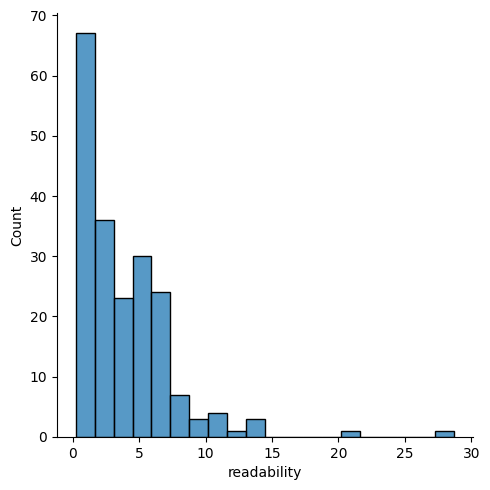

In [ ]:
# import seaborn as sns
sns.displot(df_scores, x=df_scores['readability'])

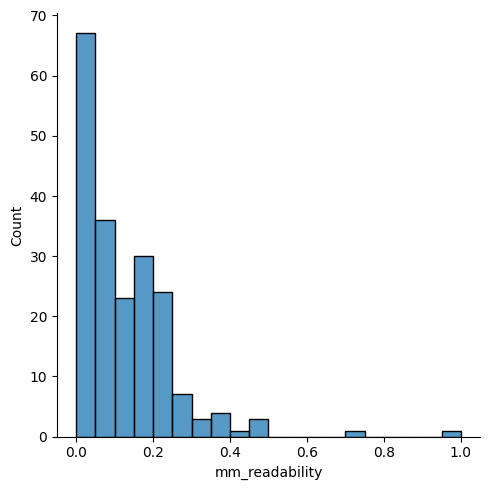

In [ ]:
#@title MinMax Scaling
from sklearn.preprocessing import MinMaxScaler
# Formats readability scores into two-dimensional array
data = df_scores['readability'].to_numpy()
data = data.reshape((-1, 1))

# Uses sklearn's MinMaxScaler to scale readability from 0 to 1
mm_scaler = MinMaxScaler()
minmax = mm_scaler.fit(data)
mm_scores = minmax.transform(data)
df_scores['mm_readability'] = np.squeeze(mm_scores).tolist()

# Plots scaled scores
sns.displot(df_scores, x='mm_readability')

In [ ]:
df_scores.loc[df_scores["mm_readability"] == 1.0]
mm_max = df_scores['text'][126] 
mm_max.replace(r'\\|[\']|\n','') 
mm_score = int(df_scores["mm_readability"].max(axis=0)) * 100
print("SCORE: ", mm_score, 
      "\n ", mm_max)

SCORE:  100 
  Locality Name : Chunari ( चुनरी )
Tehsil Name : Teonthar
District : Rewa
State : Madhya Pradesh
Division : Rewa
Language : Hindi and Devanagari,dravidian,agariya
Current Time 05:51 PM
Date: Sunday , Feb 09,2020 (IST)
Time zone: IST (UTC+5:30)
Elevation / Altitude: 135 meters. Above Seal level
Telephone Code / Std Code: 07661

Assembly constituency : Teonthar assembly constituency
Assembly MLA : shyam lal dwivedi
Lok Sabha constituency : Rewa parliamentary constituency
Parliament MP : JANARDAN MISHRA
Serpanch Name : Munsee lal singh urf (Dada)
Pin Code : 486223
Post Office Name : Jawa

Petrol pump -Alopan mata Petrolpump
Gas station in Sahijwar, Madhya Pradesh
Government hospital there and semi government school also

Teonthar Tehsil Court -
divide into 2 part
1-Teonthar nagar panchayat (population 17039
2- chakghat nagar panchayat (population 10678)
Prachalit khatha sohagi pahadh/chunnri gaao
Pus maah ters the festival of lord mahadev
Named as adhgadh nath dham mandir th

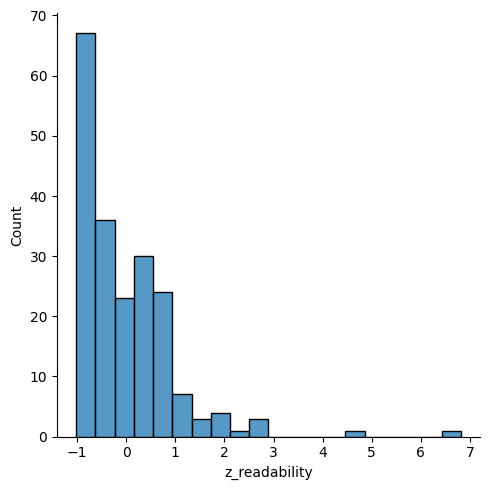

In [ ]:
#@title Z-Score Normalization 
from sklearn.preprocessing import StandardScaler

# Uses sklearn's StandardScaler to normalize readability using z-scores
zscaler = StandardScaler()
zscore = zscaler.fit(data)
z_scores = zscaler.transform(data)
df_scores['z_readability'] = np.squeeze(z_scores).tolist()

# Plots normalized scores
sns.displot(df_scores, x='z_readability')

In [ ]:
df_scores.loc[df_scores["z_readability"] == df_scores["z_readability"].max(axis=0)]
z_max = df_scores['text'][126] 
z_max.replace(r'\\|[\']|\n','') 
print("SCORE: ", df_scores["z_readability"].max(axis=0), 
      "\n ", z_max)

SCORE:  6.813695120280253 
  Locality Name : Chunari ( चुनरी )
Tehsil Name : Teonthar
District : Rewa
State : Madhya Pradesh
Division : Rewa
Language : Hindi and Devanagari,dravidian,agariya
Current Time 05:51 PM
Date: Sunday , Feb 09,2020 (IST)
Time zone: IST (UTC+5:30)
Elevation / Altitude: 135 meters. Above Seal level
Telephone Code / Std Code: 07661

Assembly constituency : Teonthar assembly constituency
Assembly MLA : shyam lal dwivedi
Lok Sabha constituency : Rewa parliamentary constituency
Parliament MP : JANARDAN MISHRA
Serpanch Name : Munsee lal singh urf (Dada)
Pin Code : 486223
Post Office Name : Jawa

Petrol pump -Alopan mata Petrolpump
Gas station in Sahijwar, Madhya Pradesh
Government hospital there and semi government school also

Teonthar Tehsil Court -
divide into 2 part
1-Teonthar nagar panchayat (population 17039
2- chakghat nagar panchayat (population 10678)
Prachalit khatha sohagi pahadh/chunnri gaao
Pus maah ters the festival of lord mahadev
Named as adhgadh nath 

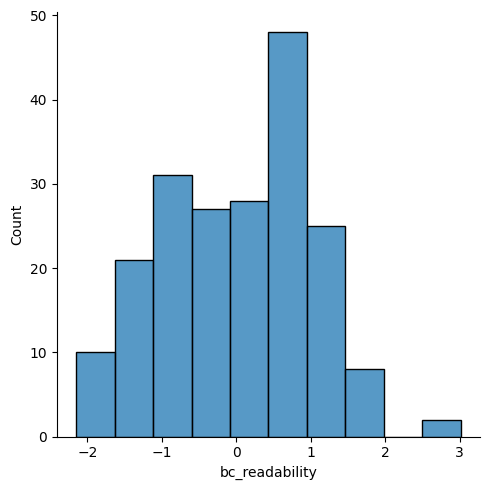

In [ ]:
#@title Box-Cox Transformation
from sklearn.preprocessing import power_transform

# Uses sklearn's power_transform to apply box-cox normalization to raw readability scores
boxcox = power_transform(data, method='box-cox')
df_scores['bc_readability'] = np.squeeze(boxcox).tolist()

# Plots transformed scores
sns.displot(df_scores, x='bc_readability')

In [ ]:
df_scores.loc[df_scores["bc_readability"] == df_scores["bc_readability"].max(axis=0)]
bc_max = df_scores['text'][126] 
bc_max.replace(r'\\|[\']|\n','') 
print("SCORE: ", df_scores["bc_readability"].max(axis=0), 
      "\n ", bc_max)

SCORE:  3.014066894872234 
  Locality Name : Chunari ( चुनरी )
Tehsil Name : Teonthar
District : Rewa
State : Madhya Pradesh
Division : Rewa
Language : Hindi and Devanagari,dravidian,agariya
Current Time 05:51 PM
Date: Sunday , Feb 09,2020 (IST)
Time zone: IST (UTC+5:30)
Elevation / Altitude: 135 meters. Above Seal level
Telephone Code / Std Code: 07661

Assembly constituency : Teonthar assembly constituency
Assembly MLA : shyam lal dwivedi
Lok Sabha constituency : Rewa parliamentary constituency
Parliament MP : JANARDAN MISHRA
Serpanch Name : Munsee lal singh urf (Dada)
Pin Code : 486223
Post Office Name : Jawa

Petrol pump -Alopan mata Petrolpump
Gas station in Sahijwar, Madhya Pradesh
Government hospital there and semi government school also

Teonthar Tehsil Court -
divide into 2 part
1-Teonthar nagar panchayat (population 17039
2- chakghat nagar panchayat (population 10678)
Prachalit khatha sohagi pahadh/chunnri gaao
Pus maah ters the festival of lord mahadev
Named as adhgadh nath 

### **DISCUSSION** ###
All three scales identified the least readable article to be an article on the Chunari locality of Madhya Pradesh, India. This could be attributed to the fact that this article uses a lot of romanized Hindi proper nouns, which would produce low WNLL scores, generating a higher RSRS per sentence. While BERT has high cultural transferability and can be trained on many different languages, it appears to struggle when computing readability on articles with romanized words from languages like Hindi. It would be interesting to see how a BERT classifier trained on Hindi and English might differ in its evaluation of the readability of this artcle.

From the three scales, the Min-Max Scaler appears to most successfully create an intuitive and clear measure of readability. Mapping the raw RSRS scores to a percentage value appears to present a readability score that is quick and easy to understand. While I did not have time to incorporate other feedback into my findings, this leaves room to extend and improve this analysis. A short survey presenting the highest and lowest scored articles for each scale as well as one random article and its associated score along each scale might be used to well describe how these transformed scores align with human intuition when it comes to text readability.

The task attempted here was definitely a challenge. There were many moving parts and I set a high standard for what I set out to accomplish through this experiment. Getting a workable model, which was really just the beginning of my initial proposal, proved to be a tough task to tackle. However, it was fulfilling to be able to build a strong, flexible model for predicting readability. With more time and resources, I would improve this analysis by using more nuanced scaling and normalizing techniques and centering human input in determining the effect of these transformations. I would also apply the SHAP framework to better understand which features were weighed most in predicting probability, and use that to understand how articles are determined to be more or less readable (Lundberg et. al, 2017).   

#### **REFERENCES** ####

1. Cambridge Linguistics Article on Cohesion and Coherence: https://www.english.cam.ac.uk/elor/lo/cohesion/index.html
2. Gunning, Robert. 1952. The Technique of Clear Writing. McGraw-Hill, New York.
3. Medium Article on Statistical Transformations: https://medium.com/@isalindgren313/transformations-scaling-and-normalization-420b2be12300
4. Matej Martinc, Senja Pollak, Marko Robnik-Šikonja; Supervised and Unsupervised Neural Approaches to Text Readability. Computational Linguistics 2021; 47 (1): 141–179. doi: https://doi.org/10.1162/coli_a_00398
5. Vajjala, Sowmya and Detmar Meurers. 2012. On improving the accuracy of readability classification using insights from second language acquisition. In Proceedings of the Seventh Workshop on Building Educational Applications Using NLP, pages 163–173, Montreal.
6. Lundberg, Scott M. and Su-In Lee. 2017. A unified approach to interpreting model predictions. In Advances in Neural Information Processing Systems, pages 4768–4777, Long Beach, CA.
7. Tensorflow Fine-Tuning Tutorial Referenced: https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert